----
# 1. 필요 라이브러리 불러오기 및 설치
----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Mecab 설치

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip install JPype1
pip install konlpy

In [3]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip install /tmp/mecab-python-0.996

In [5]:
from konlpy.tag import Mecab

mecab = Mecab()
print(mecab.morphs('자연어처리가너무재밌어서밥먹는것도가끔까먹어요'))

['자연어', '처리', '가', '너무', '재밌', '어서', '밥', '먹', '는', '것', '도', '가끔', '까먹', '어요']


In [6]:
import pandas as pd 
import tensorflow as tf
import random
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from sklearn.model_selection import train_test_split
import re
import os
import random
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

---
# 2. 데이터 불러오기
---

In [7]:
data = pd.read_csv('/content/drive/MyDrive/aiffel/Going_Deeper/GD12/data/ChatbotData.txt')
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


- 중복 확인

In [8]:
data[data.duplicated(subset=['Q','A'])]

,Q,A,label
5527,결혼이나 하지 왜 자꾸 나한테 화 내냐구!,힘들겠네요.,1
5537,고백하고 후회하면 어떡하지,후회는 후회를 낳을뿐이에요. 용기 내세요.,1
5542,공부는 내 체질이 아닌 것 같아,확신이 없나봐요.,1
5704,기숙사 괜찮을까,혼자 사는 것보다 불편하겠죠.,1
5774,나는 좋은데 ….,현실의 벽에 부딪혔나봐요.,1
...,...,...,...
8764,환승 가능?,환승은 30분 안에,1
8780,회사 사람들이 아직도 불편해,회사에는 동료가 있을 뿐이에요.,1
8782,회사에는 왜 친구 같은 사람이 없을까,회사는 친구 사귀는 곳이 아니에요.,1
8789,후련하달까,후련하니 다행이에요.,1


In [9]:
print('중복 제거 전', len(data))
data = data.drop_duplicates(subset=['Q','A'], keep = 'first')
print('중복 제거 후', len(data))

중복 제거 전 11823
중복 제거 후 11750


---
# 3. 데이터 정제하기
---

In [10]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"[^0-9a-zA-Z?!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

In [11]:
data['Q'] = data['Q'].apply(lambda x : preprocess_sentence(x))
data['A'] = data['A'].apply(lambda x : preprocess_sentence(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


- Mecab을 이용한 문장 분할

In [12]:
data['Q'] = data['Q'].apply(lambda x : ' '.join(mecab.morphs(x)))
data['A'] = data['A'].apply(lambda x : ' '.join(mecab.morphs(x)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
data.sample(5)

,Q,A,label
5184,화장 지우 고 자야 하 는데,피부 생각 하 셔야죠 !,0
4943,하 말 잘 하 는 애 들 부러워,책 을 많이 읽 어 보 세요,0
11116,좋 아 하 는 사람 이 고쳤 줬으면 하 는 거 말 해도 될까 ?,무례 하 지 않 는 선 에서 말 하 는 게 좋 아요,2
5449,갑자기 급 우울,그러니까 나 도 우울,1
983,넌 고민 이 뭐 야,저 는 고민 이 없 어요,0


In [14]:
data = data.reset_index(drop = True)
data

,Q,A,label
0,12 시 땡 !,하루 가 또 가 네요,0
1,1 지망 학교 떨어졌 어,위로 해 드립니다,0
2,3 박 4 일 놀 러 가 고 싶 다,여행 은 언제나 좋 죠,0
3,3 박 4 일 정도 놀 러 가 고 싶 다,여행 은 언제나 좋 죠,0
4,ppl 심하 네,눈살 이 찌푸려 지 죠,0
...,...,...,...
11745,훔쳐 보 는 것 도 눈치 보임,티 가 나 니까 눈치 가 보이 는 거 죠 !,2
11746,훔쳐 보 는 것 도 눈치 보임,훔쳐 보 는 거 티나 나 봐요,2
11747,흑기사 해 주 는 짝 남,설렜 겠 어요,2
11748,힘든 연애 좋 은 연애 라는 게 무슨 차이 일까 ?,잘 헤어질 수 있 는 사이 여부 인 거 같 아요,2


In [15]:
data['A'] = data['A'].apply(lambda x : '<start> ' + x + ' <end>')
data.sample(5)

,Q,A,label
3855,임신 이 면 어떡 하 지,<start> 축하 할 일 이 죠 <end>,0
2588,수염 길러 볼까,<start> 지저분 해요 <end>,0
413,김 떡 순 먹 고 싶 어,<start> 건강 을 위해 조금 씩 드세요 <end>,0
3687,이력서 몇 개 째 쓰 는 건지 모르 겠 다,<start> 좌절 하 지 마세요 <end>,0
9524,단 톡 방 에서 내 톡 에 만 답장 해 썸 각 ?,<start> 호감 이 있 을 수 도 있 어요 그렇지만 조금 더 상황 을 지켜보 세...,2


In [16]:
questions = data['Q'].to_list()
answers = data['A'].to_list()

print(len(questions))
print(len(answers))
print(questions[:5])
print(answers[:5])

11750
11750
['12 시 땡 !', '1 지망 학교 떨어졌 어', '3 박 4 일 놀 러 가 고 싶 다', '3 박 4 일 정도 놀 러 가 고 싶 다', 'ppl 심하 네']
['<start> 하루 가 또 가 네요 <end>', '<start> 위로 해 드립니다 <end>', '<start> 여행 은 언제나 좋 죠 <end>', '<start> 여행 은 언제나 좋 죠 <end>', '<start> 눈살 이 찌푸려 지 죠 <end>']


---
# 4. 토큰화
---

- 단어장 만들기

In [17]:
def tokenize(corpus, vocab_size):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                    oov_token= '<unk>',
                                                    num_words=vocab_size)
  corpus_input = [sentence.split() for sentence in corpus]
  tokenizer.fit_on_texts(corpus_input)
  return tokenizer

In [18]:
concat = pd.concat([data['Q'],data['A']])
concat

0                                        12 시 땡 !
1                                   1 지망 학교 떨어졌 어
2                             3 박 4 일 놀 러 가 고 싶 다
3                          3 박 4 일 정도 놀 러 가 고 싶 다
4                                        ppl 심하 네
                           ...                   
11745      <start> 티 가 나 니까 눈치 가 보이 는 거 죠 ! <end>
11746              <start> 훔쳐 보 는 거 티나 나 봐요 <end>
11747                       <start> 설렜 겠 어요 <end>
11748    <start> 잘 헤어질 수 있 는 사이 여부 인 거 같 아요 <end>
11749         <start> 도피성 결혼 은 하 지 않 길 바라 요 <end>
Length: 23500, dtype: object

In [19]:
tokenizer = tokenize(concat,30000)

In [20]:
print('전체 단어장의 개수: ', len(tokenizer.word_index))

전체 단어장의 개수:  6844


- 토큰화

In [21]:
def encoding_tokenizer(corpus, tokenizer):
  tensor = tokenizer.texts_to_sequences(corpus)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
  return tensor 

In [22]:
que_corpus = encoding_tokenizer(data['Q'], tokenizer)
ans_corpus = encoding_tokenizer(data['A'], tokenizer)

In [23]:
print(len(que_corpus))
print(len(ans_corpus))

11750
11750


In [357]:
que_corpus

array([[2335,  181, 4687, ...,    0,    0,    0],
       [ 281, 3344,  530, ...,    0,    0,    0],
       [ 298, 2073,  531, ...,    0,    0,    0],
       ...,
       [6284,   14,   55, ...,    0,    0,    0],
       [ 207,  109,   12, ...,    0,    0,    0],
       [  69,  276,  157, ...,    0,    0,    0]], dtype=int32)

In [358]:
ans_corpus

array([[   2,  246,    8, ...,    0,    0,    0],
       [   2,  521,   14, ...,    0,    0,    0],
       [   2,  237,   17, ...,    0,    0,    0],
       ...,
       [   2, 2288,   25, ...,    0,    0,    0],
       [   2,   47, 1613, ...,    0,    0,    0],
       [   2, 4635,  157, ...,    0,    0,    0]], dtype=int32)

---
# 5. Augmentation
---

- 데이터 프레임에 Q와 A 각각 컬럼에 augmentation을 진행하고   
추후 기존에 있던 data와 각각 augmentation을 진행한 컬럼을 합치려 한다.  

- 각 컬럼만 augmentation을 진행한다면 중복된 답변 혹은 질문이 생길 수 있으나,  
각 질문(답변)에 대해 다른 답변(질문)이 생기기 때문에 괜찮다고 생각한다.  

    ex) 12시 땡 ! == 하루가 또 가네요
        12시 끗 ! == 하루가 또 가네요

In [24]:
from gensim.models import Word2Vec

word2vec = Word2Vec.load('/content/drive/MyDrive/aiffel/Going_Deeper/GD12/data/ko/ko.bin')

In [25]:
word2vec.similar_by_word('너무')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('워낙', 0.7798625826835632),
 ('굉장히', 0.7619446516036987),
 ('상당히', 0.7366923093795776),
 ('꽤', 0.736415445804596),
 ('너무나', 0.7270296216011047),
 ('매우', 0.7263840436935425),
 ('대단히', 0.6926696300506592),
 ('아주', 0.6923656463623047),
 ('엄청', 0.6503588557243347),
 ('그만큼', 0.647625207901001)]

In [26]:
def lexical_sub(sentence, word2vec, token = True):
    res = ""
    toks = sentence.split()  
    if not token:
      toks = toks[1:-1]
      
    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

In [27]:
data_Q = data.copy()
data_A = data.copy()

In [28]:
data_Q['Q'] = data_Q['Q'].apply(lambda x : lexical_sub(x, word2vec, token = True))
data_A['A'] = data_A['A'].apply(lambda x : lexical_sub(x, word2vec, token = False))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


In [29]:
data_Q.sample(5)

,Q,A,label
6232,많이 사랑 했 나의 보 다,<start> 최선 을 다 한 건 좋 은 거 예요 <end>,1
2838,아 진짜 아쉽 으며,<start> 더 많이 배웠 길 바라 요 <end>,0
9268,여자 친구 가 연락 안 하 고 외박 했 어,<start> 당신 이 생각 하 는 그런 일 은 없 을 거 예요 <end>,2
4427,착한 사람 그러 잘 됐 으면 좋 겠 어,<start> 뿌린 대로 거둘 거 예요 <end>,0
9567,동성 을 좋아하 는 게 비 최고점 이 아닌 걸 아 는데 고백 하 는 건 망설여 져,<start> 고백 은 아무래도 더 큰 용기 가 필요 하 니까요 <end>,2


In [30]:
data_A.sample(5)

,Q,A,label
11056,좋 아 하 는 사람 이 단 톡 에서 다른 남자 한테 관심 있 는 것 같이 보여요,그렇게 느낀다면 조금 씩 정리 시키 는 게 좋 겠 어요,2
8711,회사 선배 랑 바람나 서 헤어졌 어,사랑 의 예의 가 없었 네요,1
5446,감정 에 솔직 했 을 뿐 인데 남자 들 은 싫 은 가 봐,상대방 이 상처 를 받 아서 나 봐요,1
11716,헬스 장 에서 자주 보 는 여자 가 보 고 싶 어,한 번 말로 을 걸 어 보 세요,2
2483,세금 너무 많 아,그런 감 그러 없 지 않 죠,0


- 교체할 단어가 없을 경우 None 값으로 표시되기 때문에 결측치가 발생한다. 결측치를 제거해주겠다.

In [31]:
print(len(data_Q))
print(len(data_A))

11750
11750


In [32]:
data_Q = data_Q.dropna()
data_A = data_A.dropna()

In [33]:
print(len(data_Q))
print(len(data_A))

9985
10121


In [34]:
data_arg = pd.concat([data,data_Q,data_A])
data_arg.sample(5)
print(len(data_arg))

31856


- 인덱스 초기화

In [35]:
data_arg = data_arg.reset_index(drop = True)
data_arg

,Q,A,label
0,12 시 땡 !,<start> 하루 가 또 가 네요 <end>,0
1,1 지망 학교 떨어졌 어,<start> 위로 해 드립니다 <end>,0
2,3 박 4 일 놀 러 가 고 싶 다,<start> 여행 은 언제나 좋 죠 <end>,0
3,3 박 4 일 정도 놀 러 가 고 싶 다,<start> 여행 은 언제나 좋 죠 <end>,0
4,ppl 심하 네,<start> 눈살 이 찌푸려 지 죠 <end>,0
...,...,...,...
31851,회사 에서 어떤 사람 이랑 자꾸 눈 마추 쳐,눈 마주치 는 게 우연 인지 잘 살펴 보 ㅂ시오,2
31852,회식 중 이 라고 하 는데 연락 이 안 돼,정신 없이 바쁠 지도 몰라요 조금 만 더 기다려 보 고 물 어 보 는 도록 좋 을 ...,2
31853,회식 하 는데 나 만 챙겨줘 썸 임 ?,호감 이 있 을 수 도 있 어요 그렇지만 조금 던 상황 을 지켜보 세요,2
31854,후회 없이 사랑 하 고 싶 어,헌신적 으로 다가가 보 세요,2


---
### 5-1 start / end 토큰 추가
----

- 데이터 증강을 하면서 증강된 데이터에는 start end 토큰이 없으니 해당 문장에 대해 토큰을 추가해 주겠다,

In [36]:
data_arg.sample(10)

,Q,A,label
9519,다시 태어나 도 만나 고 싶 은 사람,<start> 말 로 만 들어도 좋 겠 네요 <end>,2
21966,과일 먹 고 자 야지,제철 과일 이 정말 좋 은데요,0
18745,성탄절 다음 날 이별 했 습니다,<start> 무슨 날 인지 는 중요 하 지 않 아요 힘들 었 을 텐데 잠깐 쉬 어...,1
2331,삼겹살 먹 고 싶 다,<start> 맛나 게 드세요 <end>,0
10425,어 장 인 거 아 는 데 도 좋 아 해,<start> 마음 을 접 는 게 쉽 진 않 아요 <end>,2
29935,동네 친구 랑 썸 괜찮 을까,자주 만나 고 괜찮 을 거 예요,2
11703,한 사람 을 오랫동안 좋 아 하 는 게 신기 하 대,<start> 쉬운 일 은 아니 에요 <end>,2
19696,내 가 썸 깼 는데 다시 연락 하 고 싶 어서,<start> 감정 에 확신 이 있 다면 연락 해 보 세요 <end>,2
23596,봄 방학 했 어,부럽 군요,0
10708,오늘 백 일 이 야,<start> 축하 해요 ! <end>,2


In [37]:
for i in range(len(data_arg)):
  if data_arg['A'][i].split()[0] != '<start>':
    data_arg['A'][i] = '<start> ' + data_arg['A'][i] + ' <end>'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
data_arg

,Q,A,label
0,12 시 땡 !,<start> 하루 가 또 가 네요 <end>,0
1,1 지망 학교 떨어졌 어,<start> 위로 해 드립니다 <end>,0
2,3 박 4 일 놀 러 가 고 싶 다,<start> 여행 은 언제나 좋 죠 <end>,0
3,3 박 4 일 정도 놀 러 가 고 싶 다,<start> 여행 은 언제나 좋 죠 <end>,0
4,ppl 심하 네,<start> 눈살 이 찌푸려 지 죠 <end>,0
...,...,...,...
31851,회사 에서 어떤 사람 이랑 자꾸 눈 마추 쳐,<start> 눈 마주치 는 게 우연 인지 잘 살펴 보 ㅂ시오 <end>,2
31852,회식 중 이 라고 하 는데 연락 이 안 돼,<start> 정신 없이 바쁠 지도 몰라요 조금 만 더 기다려 보 고 물 어 보 는...,2
31853,회식 하 는데 나 만 챙겨줘 썸 임 ?,<start> 호감 이 있 을 수 도 있 어요 그렇지만 조금 던 상황 을 지켜보 세...,2
31854,후회 없이 사랑 하 고 싶 어,<start> 헌신적 으로 다가가 보 세요 <end>,2


- 데이터 섞기

In [39]:
data_arg = data_arg.sample(frac=1).reset_index(drop=True)
data_arg

,Q,A,label
0,할 수 있 습니다,<start> 할 수 있 어요 <end>,1
1,정말 모두 잊 고 새 출발 할 꺼 야,<start> 좋 은 출발 이 에요 <end>,1
2,으악 소리 지르 고 싶 다,<start> 시원 하 게 지르 고 오 세요 <end>,0
3,친구 한테 썸 중 인 거 이야기 해야 하나,<start> 확실 해 지 면 이야기 해도 늦 지 않 아요 <end>,0
4,나 도 좀 살 게 연락 좀 하 지 마,<start> 차단 하 기에 살 아요 <end>,1
...,...,...,...
31851,퇴근 하 고 놀 고 싶 다,<start> 몸 과 마음 이 좀 쉬 어야 할 것 같 아요 <end>,0
31852,공황 증,<start> 견디 기 힘들 었 를 텐데 괜찮 은 가요 <end>,1
31853,행복 해 지 고 싶 어,<start> 있 는 그대로 의 나 로 살 아야 행복 하 게 살 수 있 어요 <end>,0
31854,추워 죽 을 뻔 했 네,<start> 감기 조심 하 세요 <end>,0


---
### 5-2 Augmentation 단어장 만들기
---

In [41]:
concat_arg = pd.concat([data_arg['Q'],data_arg['A']])
concat_arg

0                                                 금값 어때
1                                      오늘 따라 엄마 보 고 싶 어
2                        짝 녀 가 내 가 좋 아 하 는 걸 알 아 버렸 어서 
3                                                또 눈 내려
4                                         많이 살 고 있 니 ? 
                              ...                      
31712                    <start> 어렵 지 는 않 을 거 예요  <end>
31713                         <start> 당장 해의 보 세요  <end>
31714                <start> 자신 만 의 시간 이 필요 한가 봐요 <end>
31715                  <start> 대중교통 을 이용 해 보 ㅂ시오  <end>
31716    <start> 다음 에 는 우산 에 이름 이랑 연락처 를 적 어 보 세요 <end>
Length: 63434, dtype: object

In [42]:
tokenizer_arg = tokenize(concat_arg,30000)

In [43]:
print('전체 단어장의 개수: ', len(tokenizer_arg.word_index))

전체 단어장의 개수:  7978


단어장의 개수가 6844 -> 7980으로 증가하였다.

- 토큰화

In [44]:
que_corpus_arg = encoding_tokenizer(data_arg['Q'], tokenizer_arg)
ans_corpus_arg = encoding_tokenizer(data_arg['A'], tokenizer_arg)

In [45]:
print(len(que_corpus_arg))
print(len(ans_corpus_arg))

31717
31717


In [46]:
que_corpus_arg

array([[4673,  490,    0, ...,    0,    0,    0],
       [ 103,  350,  517, ...,    0,    0,    0],
       [  87,  186,    8, ...,    0,    0,    0],
       ...,
       [ 864,  773,    4, ...,    0,    0,    0],
       [1290,   71,    4, ...,    0,    0,    0],
       [ 705,  985,  164, ...,    0,    0,    0]], dtype=int32)

In [47]:
ans_corpus_arg

array([[   2,  787,   73, ...,    0,    0,    0],
       [   2,  134, 2174, ...,    0,    0,    0],
       [   2,  105,  259, ...,    0,    0,    0],
       ...,
       [   2,  112,   57, ...,    0,    0,    0],
       [   2, 2181,    7, ...,    0,    0,    0],
       [   2,  432,   25, ...,    0,    0,    0]], dtype=int32)

---
# 6. 데이터 분리
---

augmentation 전 후의 데이터셋을 모두 분리하여 동일한 모델에 넣었을 때, 성능 차이를 확인해 보려 한다.

- augmentaion 전 데이터 셋 분리

In [361]:
x_train, x_test, y_train, y_test = train_test_split(que_corpus,ans_corpus, test_size=0.05, random_state = 415)

- augmentation 후 데이터 셋 분리

In [49]:
x_train_arg, x_test_arg, y_train_arg, y_test_arg = train_test_split(que_corpus_arg,ans_corpus_arg, test_size=0.05, random_state = 415)

---
# 7. 모델 설계
---

---
### 7-1. Positional Encoding
---

In [65]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

---
### 7-2. Multi-Head Attention
----

In [66]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32) # float로 변형
        QK = tf.matmul(Q, K, transpose_b=True) # np.dot과 비슷한 연산 

        # np.dot(a, b)는 a의 마지막 axis와 b의 마지막에서 두번째 axis끼리 곱한 결과를 반영하고,
        # np.matmul(a, b)는 a의 마지막 두 axis 차원이 (n, k), b의 마지막 두 axis 차원이 (k, m) 일 때, 이 사이에서만 곱하여 (n, m) 차원이 되도록 반영

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth)) # x값을 4차원으로 reshape
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3]) # 4차원 배열의 순서를 [0,1,2,3] -> [0,2,1,3]으로 변환

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

---
### 7-3. Position-wise Feed-Forward Network
---

In [67]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

---
### 7-4. Encoder 레이어 구현하기
---

In [68]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

---
### 7-5. Decoder 레이어 구현하기
---

In [69]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
                                          # Q    K    V      mask
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

---
### 7-6. Encoder / Decoder 조립하기
---

In [70]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [71]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                                                        
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()

        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

---
### 7-7. Transformer 완성하기
---

In [72]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

---
### 7-8. Mask
---

In [73]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

---
### 7-9. learning_rate 및 Optimizer
---

In [74]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

---
### 7-10. loss Function
---

In [75]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

---
### 7-11 Train Step 정의
---

In [76]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [311]:
#  Transformer 인스턴스 생성
transformer = Transformer(
                          n_layers=1,
                          d_model=368,
                          n_heads=8,
                          d_ff=1024,
                          src_vocab_size=50000,
                          tgt_vocab_size=50000,
                          pos_len=42,
                          dropout=0.2,
                          shared_fc=True,
                          shared_emb=True
                          )

---
### 7-12 Learning Rate & Optimizer
---

In [77]:
d_model = 368

learning_rate = LearningRateScheduler(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

---
### 7-13 훈련하기
---

- 데이터를 배치 사이즈 크기로 묶기

In [422]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size=BATCH_SIZE)

In [314]:
BATCH_SIZE = 64
train_dataset_aug = tf.data.Dataset.from_tensor_slices((x_train_arg, y_train_arg)).batch(batch_size=BATCH_SIZE)

In [289]:
EPOCHS = 10
loss = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()
        loss.append((total_loss.numpy() / (step + 1)))

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

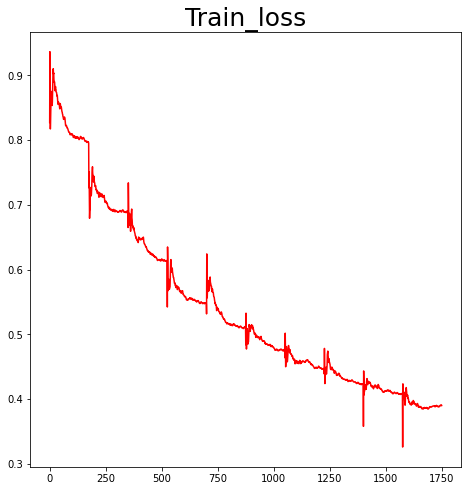

In [290]:
plt.figure(figsize=(17,8))
plt.subplot(1,2,1)
plt.title('Train_loss',fontsize = 25)
plt.plot(loss, color = 'r')

---
### 7-14 문장 테스트
---

In [85]:

def get_decoded_sentence(encoded_sentence, index_to_word):
  qwe = ''
  for index in encoded_sentence :
    if index in index_to_word:
      qwe += ' ' + index_to_word[index]
    else :
      qwe += ' <unk>'
  return qwe

In [86]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index[word] if word in word_to_index else word_to_index['<unk>'] for word in sentence]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<unk>' for index in encoded_sentence[:])  #[1:]를 통해 <BOS>를 제외

In [87]:
def evaluate(sentence, model, tokenizer, x_train, y_train):
    # sentence 전처리(enc_train과 같은 모양으로)
    word_to_index = tokenizer.word_index
    index_to_word = tokenizer.index_word
    sentence = preprocess_sentence(sentence)
    pieces = sentence
    tokens = get_encoded_sentence(pieces, word_to_index)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=x_train.shape[-1],
                                                           padding='post')
    
    ids = []
    
    output = tf.expand_dims([word_to_index["<start>"]], 0) 
    for i in range(y_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        
        # 예측 단어가 종료 토큰일 경우
        if word_to_index["<end>"] == predicted_id:
            result = get_decoded_sentence(ids, index_to_word)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns
        ##word_to_index
        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = get_decoded_sentence(ids, index_to_word)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

def translate(sentence, model, tokenizer, x_train, y_train, go = True,):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, tokenizer, x_train, y_train)
    
    if go :
      print('Input: %s' % (sentence))
      print('Predicted translation: {}'.format(result))
      print('-'*50)
    return result

In [83]:
examples = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있는다는 소리야."
]

In [295]:
for example in examples:
    translate(example, transformer, tokenizer, go = True)

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 좋 아 하 고 있 는데 연락 하 고 있 지 도 않 고 아 하 세요
--------------------------------------------------
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 그 사람 은 정말 좋 겠 네요
--------------------------------------------------
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 분위기 있 는 소중 한 추억 이 에요
--------------------------------------------------
Input: 집에 있는다는 소리야.
Predicted translation: 집 에 하 면 돼요
--------------------------------------------------


----
# 8. 성능 측정하기
----

In [88]:
def eval_bleu(src_corpus, tgt_corpus, tokenizer, transformer, x_train, y_train, go = True, verbose=True):
    total_score = 0.0
    sample_size = len(tgt_corpus)
    index_to_word = tokenizer.index_word

    for idx in tqdm(range(sample_size)):
        src_tokens = src_corpus[idx]
        tgt_tokens = tgt_corpus[idx]
        
        src = []
        tgt = []
        
        for word in src_tokens:
            if word !=0 and word !=1 and word !=3 and word !=4:
                src.append(word)
        
        for word in tgt_tokens:
            if word != 0 and word != 3 and word !=4:
                tgt.append(word)

        
        src_sentence = get_decoded_sentence(src, index_to_word)
        tgt_sentence = get_decoded_sentence(tgt, index_to_word)
        
        
        reference = preprocess_sentence(tgt_sentence)[6:]
        candidate = translate(src_sentence, transformer, tokenizer, x_train, y_train, go)

        score = sentence_bleu([reference], candidate,
                              smoothing_function=SmoothingFunction().method1)
        total_score += score

        if verbose:
            # print("Source Sentence: ", src_sentence)
            # print("Model Prediction: ", candidate)
            print("Real: ", reference)
            print("Score: %lf" % score)
            print('='*80)
    print('#'*70)
    print("Num of Sample:", sample_size)
    print("Total Score: %1f" % (total_score / sample_size))
    print('#'*70)

In [ ]:
eval_bleu(x_test[::70], y_test[::70], tokenizer, transformer, x_train, y_train, go = True , verbose=True)

In [298]:
eval_bleu(x_test, y_test, tokenizer, x_train, y_train, go = False, verbose=False)

  0%|          | 0/588 [00:00<?, ?it/s]

######################################################################
Num of Sample: 588
Total Score: 0.040684
######################################################################


---
# 9. Augmentation 데이터셋 학습
---

In [315]:
#  Transformer 인스턴스 생성
transformer2 = Transformer(
                          n_layers=1,
                          d_model=368,
                          n_heads=8,
                          d_ff=1024,
                          src_vocab_size=50000,
                          tgt_vocab_size=50000,
                          pos_len=42,
                          dropout=0.2,
                          shared_fc=True,
                          shared_emb=True
                          )

d_model = 368

In [316]:
EPOCHS = 10
loss_aug = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset_aug).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset_aug):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer2,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()
        loss_aug.append((total_loss.numpy() / (step + 1)))

  0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/471 [00:00<?, ?it/s]

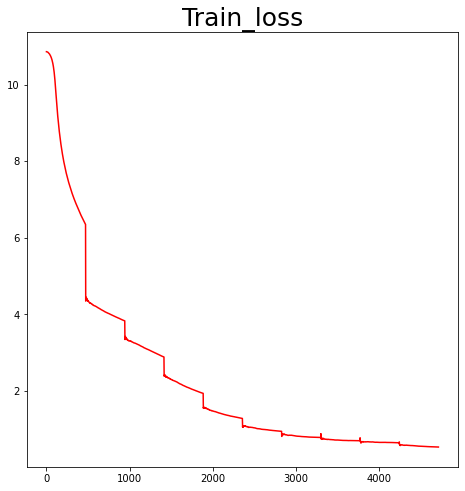

In [321]:
plt.figure(figsize=(17,8))
plt.subplot(1,2,1)
plt.title('Train_loss',fontsize = 25)
plt.plot(loss_aug, color = 'r')

In [335]:
for example in examples:
    translate(example, transformer2, tokenizer_arg, x_train_arg , y_train_arg, go = True)

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 네 말씀 해 주 세요
--------------------------------------------------
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 니 진정 한 번 크 도록 아니 니 다시 도 있 을 거 예요
--------------------------------------------------
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 확실 한 건 없 어요
--------------------------------------------------
Input: 집에 있는다는 소리야.
Predicted translation: 자신 을 좀 더 잘 다녀 봐요
--------------------------------------------------


In [338]:
eval_bleu(x_test_arg[::100], y_test_arg[::100], tokenizer_arg, transformer2, x_train_arg, y_train_arg, go = True , verbose=True)

  0%|          | 0/16 [00:00<?, ?it/s]

Input: 카페 알바 면접 간다
Predicted translation: 화장실 로 물 어 보 세요
--------------------------------------------------
Real:  저 도 해 보 고 싶 은 알바 예요
Score: 0.061132
Input: 그녀 를 닮 은 여잘 보 고
Predicted translation: 잘 했 을 만 쉬운 것 같 아요
--------------------------------------------------
Real:  남편 가 아니 라는 걸 잊 지 마세요
Score: 0.029698
Input: 군인 인데 여자 친구 보 고 싶 어
Predicted translation: 기쁜 진짜 한다면 다시 만나 보 세요
--------------------------------------------------
Real:  약간 만 참 고 기다려 보 세요
Score: 0.235884
Input: 운세 종합 해 보 니 헤어질 때 였 네
Predicted translation: 국경일 챙겨 주 기에 싶 네요
--------------------------------------------------
Real:  의미 부여 는 자신 을 더 작 게 만들 어요
Score: 0.011677
Input: 헤헤 용돈 받 았 어
Predicted translation: 언젠간 당신 에게 도 핵심적 해요
--------------------------------------------------
Real:  기분 좋 겠 어요
Score: 0.015277
Input: 좋 아 하 는 여자 애 한테 어떻게 관심 표현 하 는지 조언 좀
Predicted translation: 진짜 사랑 했 나 봐요
--------------------------------------------------
Real:  그녀 의 관심사 에 호감 을 드러내 세요
Score: 0.011586
Input: 헤어진지 한 달 되 어 가 네
Predicted tran

In [339]:
eval_bleu(x_test_arg, y_test_arg, tokenizer_arg, transformer2, x_train_arg, y_train_arg, go = False , verbose=False)

  0%|          | 0/1586 [00:00<?, ?it/s]

######################################################################
Num of Sample: 1586
Total Score: 0.046298
######################################################################


total score의 경우 미세하게 증가했다.  
다만 augmentation을 하는 과정에서 단어가 바뀌면서 인간이 글을 읽었을 때, 적합하지 않았던 단어로도 바뀌었다.  
그 결과 input문장과 predicted문장을 보면 다소 이상한 글들이 눈에 보인다.

---
# 10. 성능 개선하기
---

---
### 10-1 layer 늘려보기
----

- 기존 augmentation을 하기 전 데이터 셋을 사용해  
layer 1 -> 2로 증가시켜 변화를 확인해 보겠다.

In [380]:
#  Transformer 인스턴스 생성
transformer2 = Transformer(
                          n_layers=2,
                          d_model=368,
                          n_heads=8,
                          d_ff=1024,
                          src_vocab_size=50000,
                          tgt_vocab_size=50000,
                          pos_len=42,
                          dropout=0.2,
                          shared_fc=True,
                          shared_emb=True
                          )

In [381]:
EPOCHS = 10
loss = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer2,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()
        loss.append((total_loss.numpy() / (step + 1)))

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

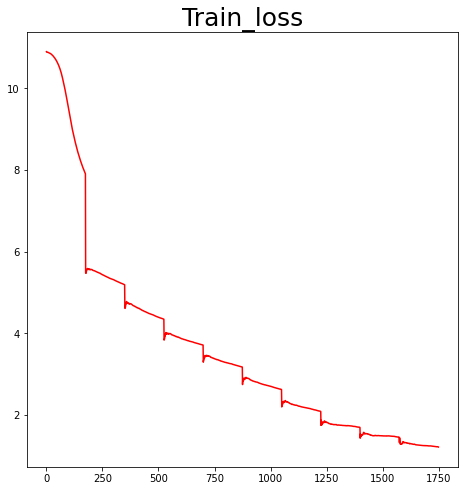

In [382]:
plt.figure(figsize=(17,8))
plt.subplot(1,2,1)
plt.title('Train_loss',fontsize = 25)
plt.plot(loss, color = 'r')

In [386]:
for example in examples:
    translate(example, transformer2, tokenizer, x_train, y_train, go = True)

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 여행 을 주 세요
--------------------------------------------------
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 예쁘 게 찍 게 찍 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 일 이
--------------------------------------------------
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 연락 을 해서 좋 아 하 는 게 좋 을 거 예요
--------------------------------------------------
Input: 집에 있는다는 소리야.
Predicted translation: 집 에 신경 을 보여 주 세요
--------------------------------------------------


In [384]:
eval_bleu(x_test[::70], y_test[::70], tokenizer, transformer2, x_train, y_train, go = True , verbose=True)

  0%|          | 0/9 [00:00<?, ?it/s]

Input: 친구 가 자꾸 클럽 을 너무 좋 아 해 맨날 가재
Predicted translation: 술 이 챙겨 주 세요
--------------------------------------------------
Real:  다른 친구 랑 가 라고 해요
Score: 0.019595
Input: 좋 아 하 는 남자 애 가 게임 을 좋아하 는데 이야기 오래가 는 소재 좀 알려줘
Predicted translation: 이야기 를 이야기 라 생각 하 게 필요 하 게 좋 을 거 예요
--------------------------------------------------
Real:  요즘 인기 있 는 게임 을 검색 해봐요
Score: 0.045571
Input: 사랑 은 시간 약 인가 ?
Predicted translation: 챙겨 주 면서 버리 세요
--------------------------------------------------
Real:  시간 약인 경우 가 많 아요
Score: 0.019920
Input: 혼자 영화 보 러 왔 어
Predicted translation: 신혼 일 이 될 거 예요
--------------------------------------------------
Real:  온전히 느낄 수 있 는 시간 겠 네요
Score: 0.014192
Input: 헤어진지 1 년 면 재회 는 힘들 겠 죠
Predicted translation: 그리움 을 때 의 자유 일 이 네요
--------------------------------------------------
Real:  후회 하 지 않 을 자신 있 다면 연락 해 보 세요
Score: 0.046926
Input: 시간 에 라면 먹 고 싶 은데 살 찔 거 같 아
Predicted translation: 신경 쓰이 게 좋 을 거 예요
--------------------------------------------------
Real:  간단 한 견과 류 나 과일 을 먹 어 보 

In [385]:
eval_bleu(x_test, y_test, tokenizer, transformer2, x_train, y_train, go = False , verbose=False)

  0%|          | 0/588 [00:00<?, ?it/s]

######################################################################
Num of Sample: 588
Total Score: 0.040763
######################################################################


예측 문장이나 total score나 특별히 개선된 점이 있어 보이지는 않는다.

---
### 10-2 layer 늘려보기
----

- 기존 augmentation을 하기 전 데이터 셋을 사용해  
layer 2 -> 4로 증가시켜 변화를 확인해 보겠다.

In [401]:
#  Transformer 인스턴스 생성
transformer3 = Transformer(
                          n_layers=4,
                          d_model=368,
                          n_heads=8,
                          d_ff=1024,
                          src_vocab_size=50000,
                          tgt_vocab_size=50000,
                          pos_len=42,
                          dropout=0.2,
                          shared_fc=True,
                          shared_emb=True
                          )

In [402]:
EPOCHS = 10
loss3 = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer3,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()
        loss3.append((total_loss.numpy() / (step + 1)))

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

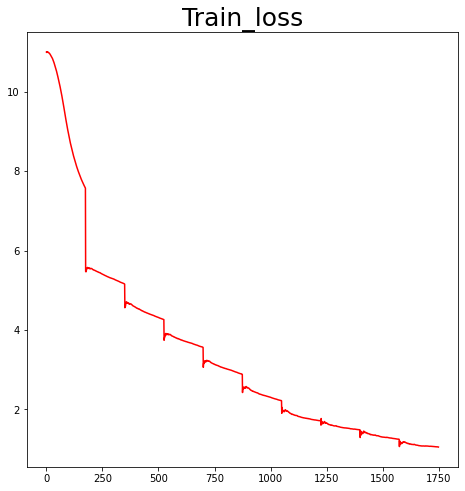

In [403]:
plt.figure(figsize=(17,8))
plt.subplot(1,2,1)
plt.title('Train_loss',fontsize = 25)
plt.plot(loss3, color = 'r')

In [404]:
for example in examples:
    translate(example, transformer3, tokenizer, x_train, y_train, go = True)

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 질 수 있 다니 다행 이 에요
--------------------------------------------------
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 그분 을 더 잘 버티 다니 괜찮 겠 어요
--------------------------------------------------
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 좋 은 일 거 예요
--------------------------------------------------
Input: 집에 있는다는 소리야.
Predicted translation: 조심히 괜찮 아요
--------------------------------------------------


In [405]:
eval_bleu(x_test[::70], y_test[::70], tokenizer, transformer3, x_train, y_train, go = True , verbose=True)

  0%|          | 0/9 [00:00<?, ?it/s]

Input: 친구 가 자꾸 클럽 을 너무 좋 아 해 맨날 가재
Predicted translation: 괜찮 아 지 않 나 봐요
--------------------------------------------------
Real:  다른 친구 랑 가 라고 해요
Score: 0.020849
Input: 좋 아 하 는 남자 애 가 게임 을 좋아하 는데 이야기 오래가 는 소재 좀 알려줘
Predicted translation: 하나 봐요
--------------------------------------------------
Real:  요즘 인기 있 는 게임 을 검색 해봐요
Score: 0.005126
Input: 사랑 은 시간 약 인가 ?
Predicted translation: 좋 은 점 이 니까 좋 은 거 예요
--------------------------------------------------
Real:  시간 약인 경우 가 많 아요
Score: 0.015936
Input: 혼자 영화 보 러 왔 어
Predicted translation: 기분 전환 을 해 보 세요
--------------------------------------------------
Real:  온전히 느낄 수 있 는 시간 겠 네요
Score: 0.015135
Input: 헤어진지 1 년 면 재회 는 힘들 겠 죠
Predicted translation: 천천히 지워질 거 예요
--------------------------------------------------
Real:  후회 하 지 않 을 자신 있 다면 연락 해 보 세요
Score: 0.011939
Input: 시간 에 라면 먹 고 싶 은데 살 찔 거 같 아
Predicted translation: 그게 먹 고 자 는 게 좋 겠 네요
--------------------------------------------------
Real:  간단 한 견과 류 나 과일 을 먹 어 보 세요
Score: 0.049655
Input

In [406]:
eval_bleu(x_test, y_test, tokenizer, transformer3, x_train, y_train, go = False , verbose=False)

  0%|          | 0/588 [00:00<?, ?it/s]

######################################################################
Num of Sample: 588
Total Score: 0.045379
######################################################################


total score는 오히려 떨어졌다. 

---
### 10-3 d_ff 줄여보기
---

- layer는 4 -> 2로 이전의 값을 사용
- d_ff는 1024 -> 512로 감소

In [423]:
#  Transformer 인스턴스 생성
transformer4 = Transformer(
                          n_layers=4,
                          d_model=368,
                          n_heads=8,
                          d_ff=512,
                          src_vocab_size=50000,
                          tgt_vocab_size=50000,
                          pos_len=42,
                          dropout=0.2,
                          shared_fc=True,
                          shared_emb=True
                          )

In [424]:
EPOCHS = 10
loss4 = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer4,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()
        loss4.append((total_loss.numpy() / (step + 1)))

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

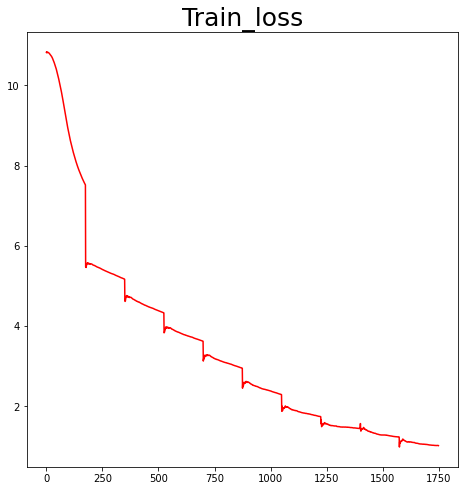

In [425]:
plt.figure(figsize=(17,8))
plt.subplot(1,2,1)
plt.title('Train_loss',fontsize = 25)
plt.plot(loss4, color = 'r')

In [426]:
for example in examples:
    translate(example, transformer4, tokenizer, x_train, y_train, go = True)

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 추억 에서 핑계 로 살 고 싶 네요
--------------------------------------------------
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 공부 는 사랑 은 시작 이 죠
--------------------------------------------------
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 천천히 대화 를 의식 하 는 게 좋 겠 네요
--------------------------------------------------
Input: 집에 있는다는 소리야.
Predicted translation: 남 은 용기 내 서 용기 내 집 에 남 은 공부 할 거 예요
--------------------------------------------------


In [427]:
eval_bleu(x_test[::70], y_test[::70], tokenizer, transformer4, x_train, y_train, go = True , verbose=True)

  0%|          | 0/9 [00:00<?, ?it/s]

Input: 친구 가 자꾸 클럽 을 너무 좋 아 해 맨날 가재
Predicted translation: 지금 은 달라진 모습 을 어필 하 고 나가 는 게 좋 겠 네요
--------------------------------------------------
Real:  다른 친구 랑 가 라고 해요
Score: 0.020054
Input: 좋 아 하 는 남자 애 가 게임 을 좋아하 는데 이야기 오래가 는 소재 좀 알려줘
Predicted translation: 추억 에 도 모르 고 있 다면 미리 마련 이 보 세요
--------------------------------------------------
Real:  요즘 인기 있 는 게임 을 검색 해봐요
Score: 0.042155
Input: 사랑 은 시간 약 인가 ?
Predicted translation: 남 을 의식 하 는 게 좋 을 거 예요
--------------------------------------------------
Real:  시간 약인 경우 가 많 아요
Score: 0.014296
Input: 혼자 영화 보 러 왔 어
Predicted translation: 천천히 일상 으로 다시 후련 하 는 사람 은 없 어요
--------------------------------------------------
Real:  온전히 느낄 수 있 는 시간 겠 네요
Score: 0.049052
Input: 헤어진지 1 년 면 재회 는 힘들 겠 죠
Predicted translation: 연인 이 면 만났 네요
--------------------------------------------------
Real:  후회 하 지 않 을 자신 있 다면 연락 해 보 세요
Score: 0.012987
Input: 시간 에 라면 먹 고 싶 은데 살 찔 거 같 아
Predicted translation: 축구 볼 수 있 을 거 예요
-----------------------------------------------

In [428]:
eval_bleu(x_test, y_test, tokenizer, transformer4, x_train, y_train, go = False , verbose=False)

  0%|          | 0/588 [00:00<?, ?it/s]

######################################################################
Num of Sample: 588
Total Score: 0.048903
######################################################################


---
### 10-4 Layer 늘려보기 - Augmentation
---

- 10-1 과 동일하게 layer를 1 -> 2로 늘려보겠다.
- 데이터셋은 augmentation을 한 데이터셋을 사용

In [ ]:
#  Transformer 인스턴스 생성
transformer_arg = Transformer(
                          n_layers=2,
                          d_model=368,
                          n_heads=8,
                          d_ff=1024,
                          src_vocab_size=50000,
                          tgt_vocab_size=50000,
                          pos_len=42,
                          dropout=0.2,
                          shared_fc=True,
                          shared_emb=True
                          )


In [ ]:
d_model = 368

learning_rate = LearningRateScheduler(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
EPOCHS = 10
loss_aug2 = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset_aug).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset_aug):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer_arg,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()
        loss_aug2.append((total_loss.numpy() / (step + 1)))

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

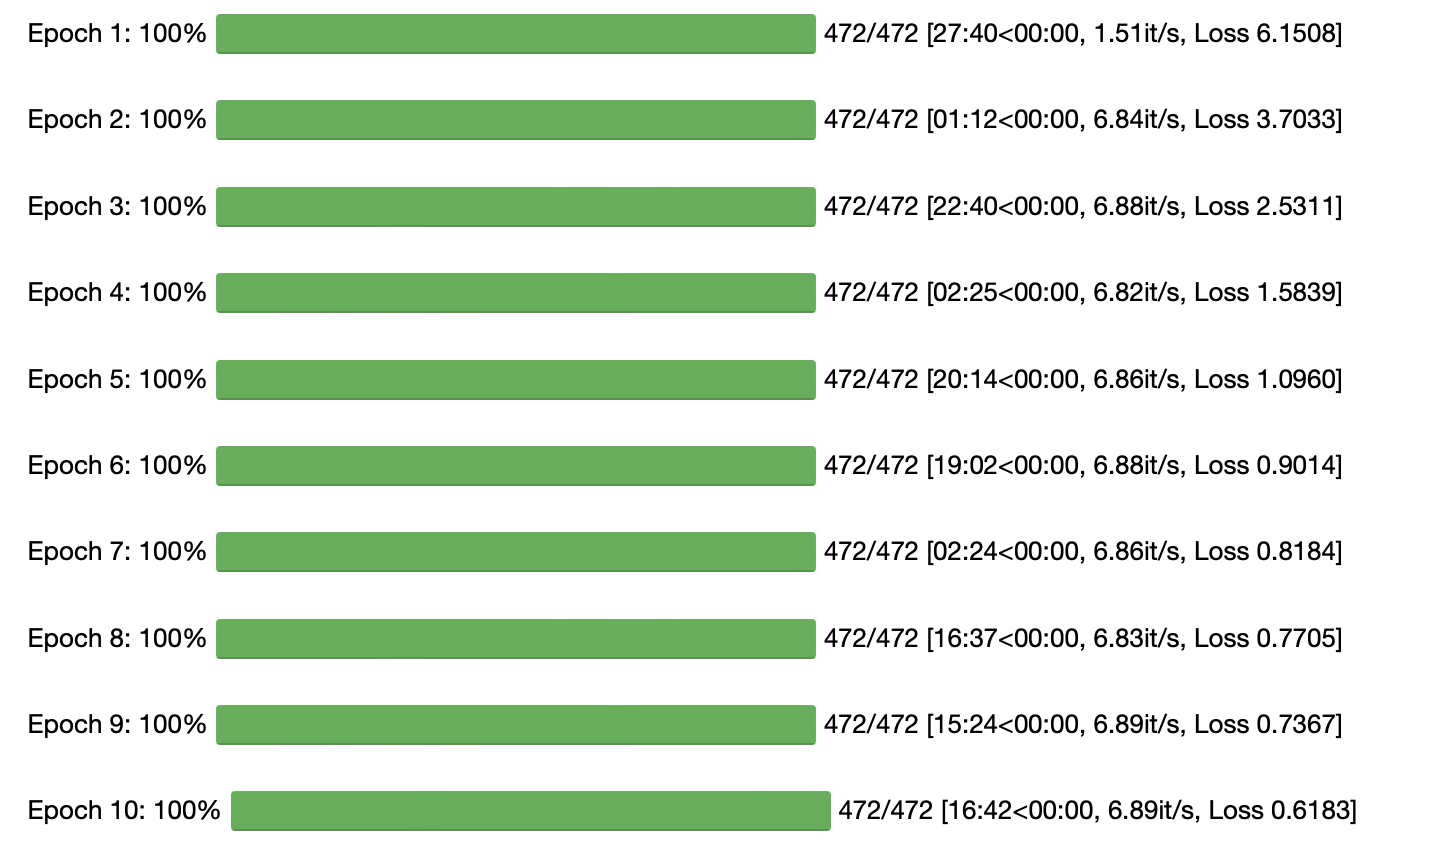

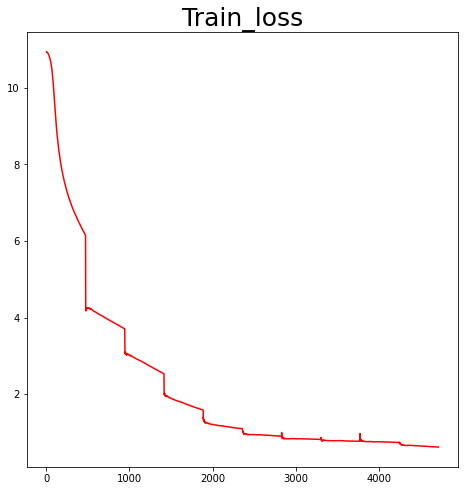

In [ ]:
plt.figure(figsize=(17,8))
plt.subplot(1,2,1)
plt.title('Train_loss',fontsize = 25)
plt.plot(loss_aug2, color = 'r')

In [ ]:
for example in examples:
    translate(example, transformer_arg, tokenizer_arg, x_train_arg, y_train_arg , go = True)

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 그 사람 에게 물 어 보 면서 더 잘 찾아보 세요
--------------------------------------------------
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 금방 나아졌 길 바랄 게요
--------------------------------------------------
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 그래도 상관없 어요 칭찬 해 주 어요
--------------------------------------------------
Input: 집에 있는다는 소리야.
Predicted translation: 제 가 있 에요
--------------------------------------------------


In [ ]:
eval_bleu(x_test_arg[::100], y_test_arg[::100], tokenizer_arg, transformer_arg, x_train_arg, y_train_arg, go = True , verbose=True)

  0%|          | 0/16 [00:00<?, ?it/s]

Input: 말 도 안 이루어지 는 이유 로 결별 선언 하 는 그녀
Predicted translation: 그때 마음 의 정리 가 잘 지내 기 도 하 겠 네요
--------------------------------------------------
Real:  진짜 이유 를 말 하 지 못하 는 사정 있 나 봐요
Score: 0.055010
Input: 내 가 좋 아 하 ㄴ다는 사람 나 안 좋아하 는 거 같 아
Predicted translation: 제 가 곁 에 있 을게요
--------------------------------------------------
Real:  슬픈 이야기 네요
Score: 0.020448
Input: 먹 을 거 하나 도 없 어
Predicted translation: 잘 견디 고 있 어요
--------------------------------------------------
Real:  장 보 러 갈 타이밍 네요
Score: 0.021459
Input: 썸 인지 착각 인지
Predicted translation: 계속 연락 하 지 않 는다면 정리 하 지 않 아요
--------------------------------------------------
Real:  ㄹ 수록 연락 오 는지 확인 해 보 세요
Score: 0.132545
Input: 고백 언제 하 꼼짝
Predicted translation: 사랑 도 잘 지내 는지 도 모르 겠 는데요
--------------------------------------------------
Real:  고백 은 타이밍 입니다
Score: 0.010900
Input: 내일 밤 샜 어
Predicted translation: 연락 을 하 지 마세요
--------------------------------------------------
Real:  건강 에 안 좋 아요
Score: 0.025471
Input: 나 한테 상 의 좀 하 지
Predicted translation:

In [ ]:
eval_bleu(x_test_arg, y_test_arg, tokenizer_arg, transformer_arg, x_train_arg, y_train_arg, go = False , verbose=False)

  0%|          | 0/1590 [00:00<?, ?it/s]

######################################################################
Num of Sample: 1590
Total Score: 0.049502
######################################################################


---
### 10-5 Layer 늘려보기 - Augmentation
---

- 10-4에 이어 layer를 2 -> 4로 늘려 보겠다.

In [ ]:
#  Transformer 인스턴스 생성
transformer_arg2 = Transformer(
                          n_layers=4,
                          d_model=368,
                          n_heads=8,
                          d_ff=1024,
                          src_vocab_size=50000,
                          tgt_vocab_size=50000,
                          pos_len=42,
                          dropout=0.2,
                          shared_fc=True,
                          shared_emb=True
                          )



In [ ]:
EPOCHS = 10
loss_aug2 = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset_aug).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset_aug):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer_arg2,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()
        loss_aug2.append((total_loss.numpy() / (step + 1)))

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

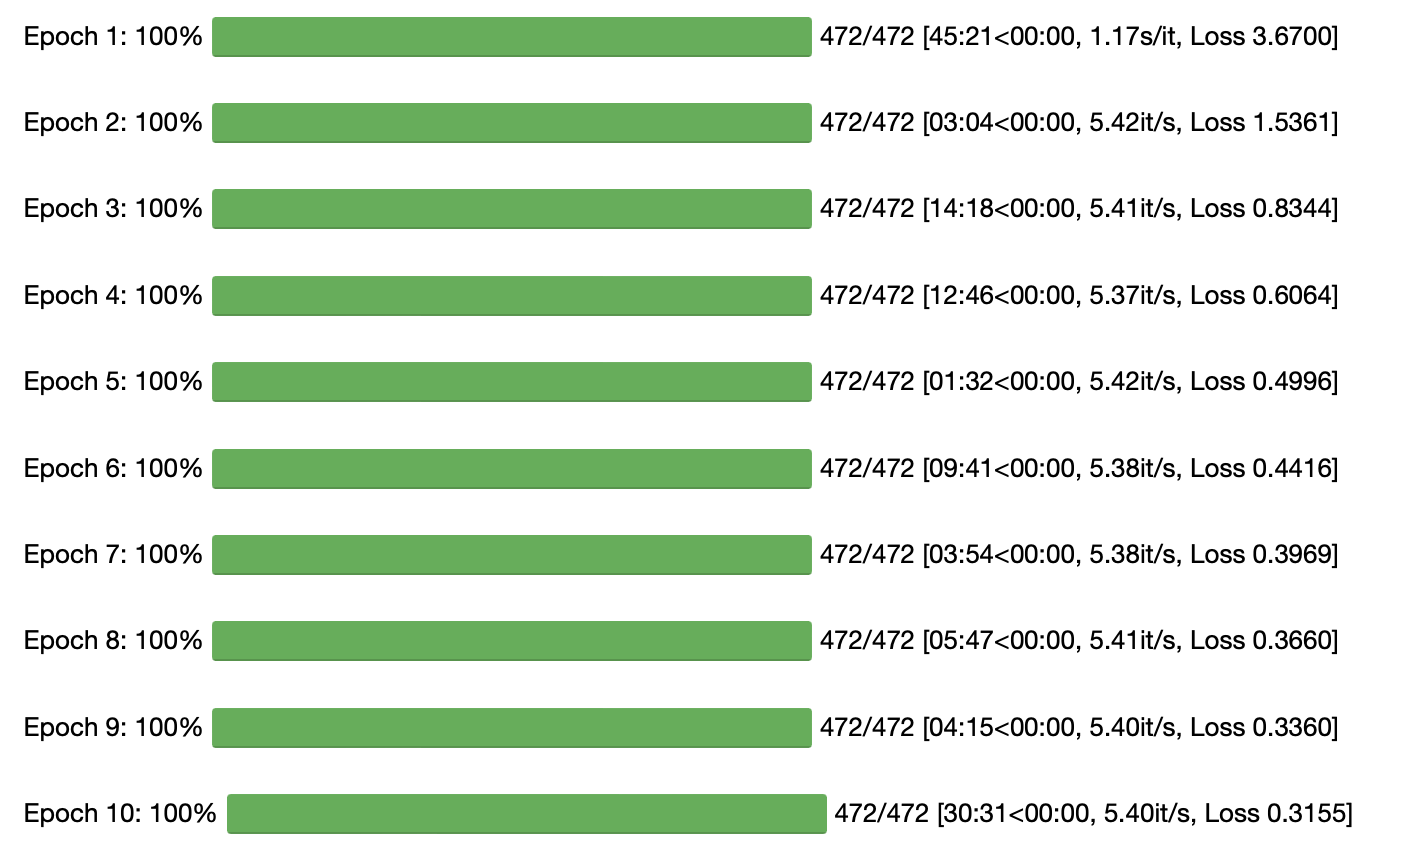

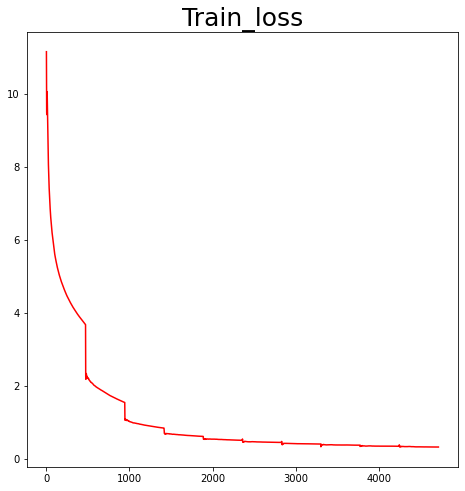

In [ ]:
plt.figure(figsize=(17,8))
plt.subplot(1,2,1)
plt.title('Train_loss',fontsize = 25)
plt.plot(loss_aug2, color = 'r')

In [ ]:
for example in examples:
    translate(example, transformer_arg2, tokenizer_arg, x_train_arg, y_train_arg , go = True)

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 용기 를 내보 는 게 좋 아요
--------------------------------------------------
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 더 일찍 벌어지 세요
--------------------------------------------------
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 연인 과 연락 을 두 대화 로 받 로 좋 아요
--------------------------------------------------
Input: 집에 있는다는 소리야.
Predicted translation: 가장 확실 한 시간 은 오늘 이 에요
--------------------------------------------------


In [ ]:
eval_bleu(x_test_arg[::200], y_test_arg[::200], tokenizer_arg, transformer_arg2, x_train_arg, y_train_arg, go = True , verbose=True)

  0%|          | 0/8 [00:00<?, ?it/s]

Input: 말 도 안 이루어지 는 이유 로 결별 선언 하 는 그녀
Predicted translation: 연인 은 살쪄 도 잘 될 거 예요
--------------------------------------------------
Real:  진짜 이유 를 말 하 지 못하 는 사정 있 나 봐요
Score: 0.010424
Input: 먹 을 거 하나 도 없 어
Predicted translation: 연인 과 함께 면 깔끔 하 게 해요
--------------------------------------------------
Real:  장 보 러 갈 타이밍 네요
Score: 0.015936
Input: 고백 언제 하 꼼짝
Predicted translation: 연인 를 맞이 할 뿐 이 에요
--------------------------------------------------
Real:  고백 은 타이밍 입니다
Score: 0.017396
Input: 나 한테 상 의 좀 하 지
Predicted translation: 연인 를 좋아해 줬 으면 좋 겠 네요
--------------------------------------------------
Real:  이야기 를 하 지 않 고 결정 했 나 봐요
Score: 0.053988
Input: 가끔 은 혼자 인 게 좋 다
Predicted translation: 깔끔 한 게 좋 죠
--------------------------------------------------
Real:  혼자 를 즐기 세요
Score: 0.027776
Input: 라면 먹 고 겠 어
Predicted translation: 그때 카톡 해 보 세요
--------------------------------------------------
Real:  맛나 게 끓여 드세요
Score: 0.045294
Input: 짝 녀 가 날 너무 친구 로 생각 해
Predicted translation: 그것 만큼 마음 의 정리 를 됐 네요


In [ ]:
eval_bleu(x_test_arg, y_test_arg, tokenizer_arg, transformer_arg2, x_train_arg, y_train_arg, go = False , verbose=False)

  0%|          | 0/1590 [00:00<?, ?it/s]

######################################################################
Num of Sample: 1590
Total Score: 0.053672
######################################################################


---
### 10-6 d_ff 줄여보기 - Augmentation
---

- 10-3과 동일하게 d_ff를 1024 -> 512로 감소
- layer의 경우 10-4 보다 10-5의 성능이 근소하게 증가한 것으로 보아 4를 그대로 사용

In [ ]:
#  Transformer 인스턴스 생성
transformer_arg3 = Transformer(
                          n_layers=4,
                          d_model=368,
                          n_heads=8,
                          d_ff=512,
                          src_vocab_size=50000,
                          tgt_vocab_size=50000,
                          pos_len=42,
                          dropout=0.2,
                          shared_fc=True,
                          shared_emb=True
                          )




In [ ]:
EPOCHS = 10
loss_aug3 = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset_aug).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset_aug):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer_arg3,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()
        loss_aug3.append((total_loss.numpy() / (step + 1)))

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

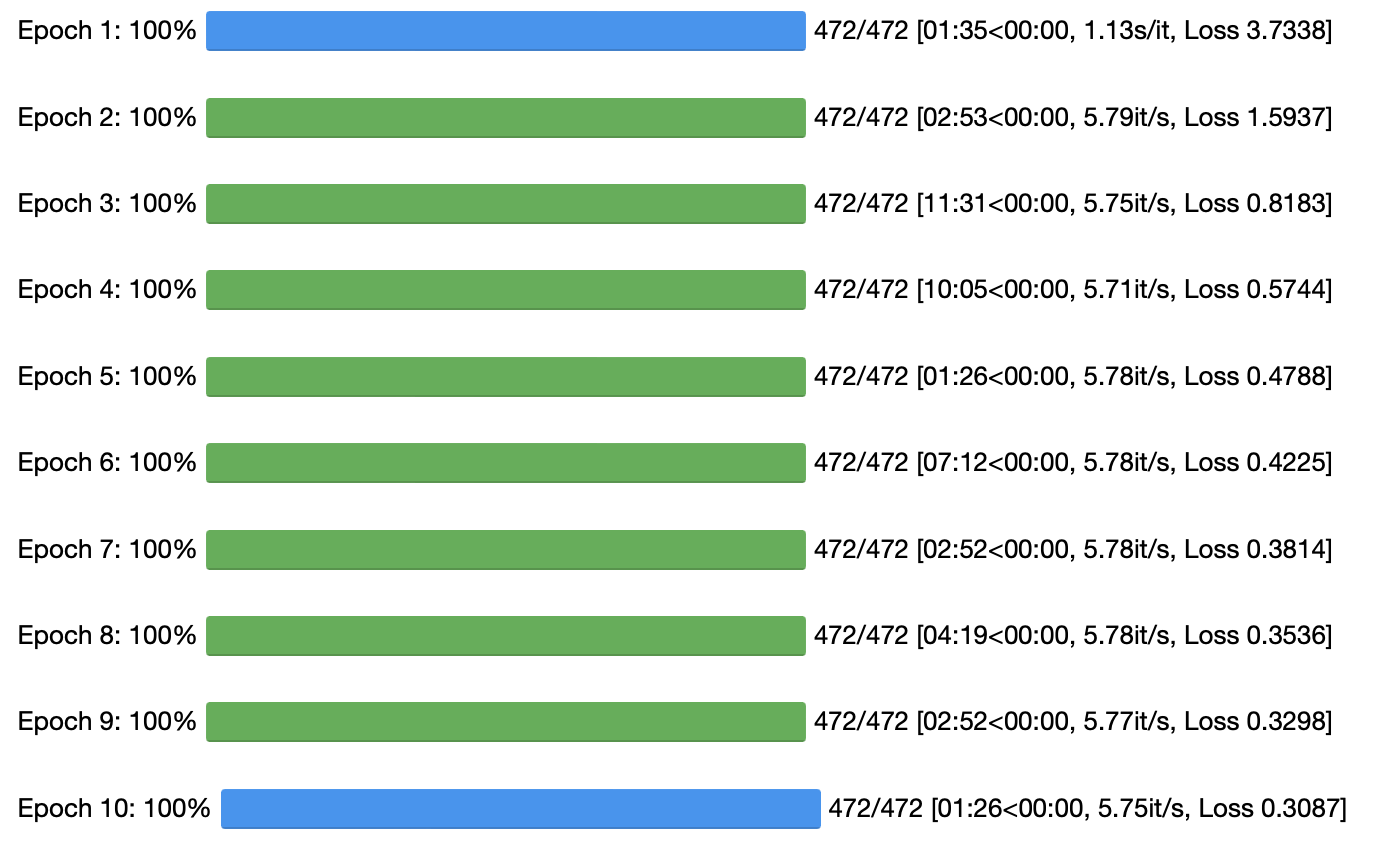

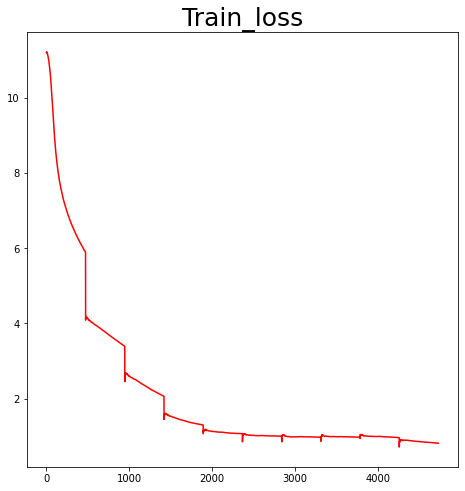

In [ ]:
plt.figure(figsize=(17,8))
plt.subplot(1,2,1)
plt.title('Train_loss',fontsize = 25)
plt.plot(loss_aug3, color = 'r')

In [ ]:
for example in examples:
    translate(example, transformer_arg3, tokenizer_arg, x_train_arg, y_train_arg , go = True)

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 같이 여행 도 도움 을 해 보 세요
--------------------------------------------------
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 뭐 라고 대답 할지 도 몰라요
--------------------------------------------------
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 때로 는 친구 가 예민 하 면 가능 하 죠
--------------------------------------------------
Input: 집에 있는다는 소리야.
Predicted translation: 뭐 로 냐고 연락 해 보 세요
--------------------------------------------------


In [ ]:
eval_bleu(x_test_arg[::200], y_test_arg[::200], tokenizer_arg, transformer_arg3, x_train_arg, y_train_arg, go = True , verbose=True)

  0%|          | 0/8 [00:00<?, ?it/s]

Input: 사랑 하 는데 꼭 결혼 해야 할지 는 모르 겠 어요
Predicted translation: 뭐 라고 하 고 싶 은 걸 지도 몰라요
--------------------------------------------------
Real:  사랑 과 결혼 을 동일시 하 지 않 아도 돼요 시간 을 가지 고 생각 해 보 세요
Score: 0.032556
Input: 바오로 는 날 뭐 해 ?
Predicted translation: 뭐 라고 하 냐고 바닷물 어 보 세요
--------------------------------------------------
Real:  실내 데이트 요
Score: 0.012674
Input: 너무 가슴 그러 아파
Predicted translation: 저 도 싫 어 하 고 싶 어요
--------------------------------------------------
Real:  무슨 마음 인지 알 겠 어서 더 마음 아프 네요
Score: 0.020279
Input: 친구 인의 친구 를 사랑 하 는 거 같 아
Predicted translation: 헤어지 면 스트레스 받 겠 네요
--------------------------------------------------
Real:  슬픈 이야기 네요
Score: 0.061175
Input: 많이 슬퍼하 고 그리워 해야
Predicted translation: 거절 하 고 싶 은 곳 인가 봐요
--------------------------------------------------
Real:  이런 과정 도 반드시 필요 해요
Score: 0.016907
Input: 못생긴 남자 를 좋아하 는 여자 가 있 을지
Predicted translation: 빨리 시작 하 면 가능 하 는 게 좋 겠 네요
--------------------------------------------------
Real:  외모 가 중요 한 시대 는 끝 났 어요
Score: 0.063057
I

In [ ]:
eval_bleu(x_test_arg, y_test_arg, tokenizer_arg, transformer_arg3, x_train_arg, y_train_arg, go = False , verbose=False)

  0%|          | 0/1592 [00:00<?, ?it/s]

######################################################################
Num of Sample: 1592
Total Score: 0.049090
######################################################################


---
### 10-7 Augmentation twice 
---

In [41]:
data_aug_Q = data_arg.copy()
data_aug_A = data_arg.copy()

In [42]:
data_aug_Q['Q'] = data_aug_Q['Q'].apply(lambda x : lexical_sub(x, word2vec, token = True))
data_aug_A['A'] = data_aug_A['A'].apply(lambda x : lexical_sub(x, word2vec, token = False))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


- 결측치 제거

In [47]:
print(len(data_aug_Q))
print(len(data_aug_A))

31856
31856


In [48]:
data_aug_Q = data_aug_Q.dropna()
data_aug_A = data_aug_A.dropna()

In [49]:
print(len(data_aug_Q))
print(len(data_aug_A))

27291
27756


In [50]:
data_aug_twice = pd.concat([data_arg,data_aug_Q,data_aug_A])
data_aug_twice.sample(5)
print(len(data_aug_twice))

86903


- 인덱스 초기화

In [51]:
data_aug_twice = data_aug_twice.reset_index(drop = True)
data_aug_twice

,Q,A,label
0,할 수 있 습니다,<start> 할 수 있 어요 <end>,1
1,정말 모두 잊 고 새 출발 할 꺼 야,<start> 좋 은 출발 이 에요 <end>,1
2,으악 소리 지르 고 싶 다,<start> 시원 하 게 지르 고 오 세요 <end>,0
3,친구 한테 썸 중 인 거 이야기 해야 하나,<start> 확실 해 지 면 이야기 해도 늦 지 않 아요 <end>,0
4,나 도 좀 살 게 연락 좀 하 지 마,<start> 차단 하 기에 살 아요 <end>,1
...,...,...,...
86898,퇴근 하 고 놀 고 싶 다,몸 과 마음 이 좀 쉬 여야 할 것 같 아요,0
86899,공황 증,견디 기 힘들 었 를 텐데 괜찮 은 예능,1
86900,행복 해 지 고 싶 어,없 는 그대로 의 나 로 살 아야 행복 하 게 살 수 있 어요,0
86901,추워 죽 을 뻔 했 네,감기 변덕 하 세요,0


In [52]:
for i in range(len(data_aug_twice)):
  if data_aug_twice['A'][i].split()[0] != '<start>':
    data_aug_twice['A'][i] = '<start> ' + data_aug_twice['A'][i] + ' <end>'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


- 데이터 섞기

In [54]:
data_aug_twice = data_aug_twice.sample(frac=1).reset_index(drop=True)
data_aug_twice

,Q,A,label
0,썸녀 주변 에 남자 놀드 많 아,<start> 신경 읽히 겠 네요 <end>,2
1,헤어지 고 4 달째,<start> 많 은 시간 이 흘렀 네요 <end>,1
2,취직 하 고 싶 어,<start> 원 시키 는 곳 에 취직 할 수 있 을 거 예요 <end>,0
3,자존 감 어떻 게 올려 ?,<start> 잘 하 고 있 다고 괜찮 다고 스스로 에게 말 해 살펴보 세요 <end>,0
4,이젠 그냥 조금 만 자극 이 와도 눈물 이,<start> 이별 은 치명상 을 남기 고 가 니까요 <end>,1
...,...,...,...
86898,너무 잘 하 는 후배 가 들어왔 어,<start> 배울 점 은 배우 세요 <end>,0
86899,졸업식 에 가 도 되 나,<start> 졸업식 에 가 불쌍히 축하 해 주 세요 <end>,0
86900,신발 에 빵꾸 난 거 봤 나,<start> 괜찮 아요 그럴 수 도 있 죠 <end>,0
86901,내 친구 랑 내 짝 녀 가 서로 좋아하 는 방법 같 은데 나 어떡 함 ?,<start> 빨리 마음 을 정리 하 는 게 필요 하 겠 어요 <end>,2


In [56]:
concat_aug_twice = pd.concat([data_aug_twice['Q'],data_aug_twice['A']])
concat_aug_twice

0                               썸녀 주변 에 남자 놀드 많 아 
1                                       헤어지 고 4 달째
2                                       취직 하 고 싶 어
3                                   자존 감 어떻 게 올려 ?
4                          이젠 그냥 조금 만 자극 이 와도 눈물 이
                           ...                    
86898                   <start> 배울 점 은 배우 세요 <end>
86899         <start> 졸업식 에 가 불쌍히 축하 해 주 세요  <end>
86900               <start> 괜찮 아요 그럴 수 도 있 죠 <end>
86901    <start> 빨리 마음 을 정리 하 는 게 필요 하 겠 어요  <end>
86902           <start> 새로운 도전 은 용기 가 필요 하 죠 <end>
Length: 173806, dtype: object

In [58]:
tokenizer_aug_twice = tokenize(concat_aug_twice,30000)

In [59]:
print('전체 단어장의 개수: ', len(tokenizer_aug_twice.word_index))

전체 단어장의 개수:  8784


- 토큰화

In [60]:
que_corpus_aug_twice = encoding_tokenizer(data_aug_twice['Q'], tokenizer_aug_twice)
ans_corpus_aug_twice = encoding_tokenizer(data_aug_twice['A'], tokenizer_aug_twice)

In [61]:
print(len(que_corpus_aug_twice))
print(len(ans_corpus_aug_twice))

86903
86903


In [63]:
que_corpus_aug_twice.shape

(86903, 32)

- 데이터 셋 분리

In [64]:
x_train_twice, x_test_twice, y_train_twice, y_test_twice = train_test_split(que_corpus_aug_twice,ans_corpus_aug_twice, test_size=0.01, random_state = 415)

In [78]:
BATCH_SIZE = 64
train_dataset_aug_twice = tf.data.Dataset.from_tensor_slices((x_train_twice, y_train_twice)).batch(batch_size=BATCH_SIZE)

In [79]:
#  Transformer 인스턴스 생성
transformer_arg4 = Transformer(
                          n_layers=2,
                          d_model=256,
                          n_heads=8,
                          d_ff=1024,
                          src_vocab_size=10000,
                          tgt_vocab_size=10000,
                          pos_len=40,
                          dropout=0.3,
                          shared_fc=True,
                          shared_emb=True
                          )




In [80]:
EPOCHS = 10
loss_aug_twice = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset_aug_twice).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset_aug_twice):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer_arg4,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()
        loss_aug_twice.append((total_loss.numpy() / (step + 1)))

  0%|          | 0/1345 [00:00<?, ?it/s]

  0%|          | 0/1345 [00:00<?, ?it/s]

  0%|          | 0/1345 [00:00<?, ?it/s]

  0%|          | 0/1345 [00:00<?, ?it/s]

  0%|          | 0/1345 [00:00<?, ?it/s]

  0%|          | 0/1345 [00:00<?, ?it/s]

  0%|          | 0/1345 [00:00<?, ?it/s]

  0%|          | 0/1345 [00:00<?, ?it/s]

  0%|          | 0/1345 [00:00<?, ?it/s]

  0%|          | 0/1345 [00:00<?, ?it/s]

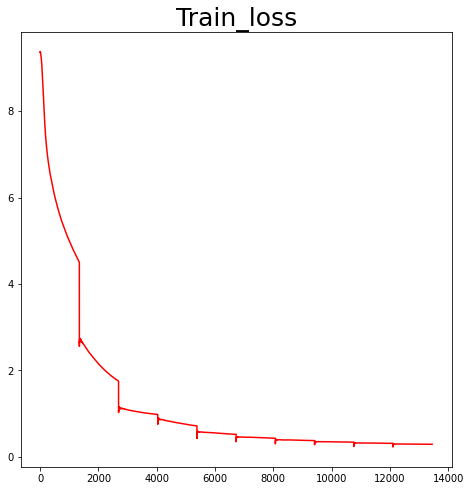

In [81]:
plt.figure(figsize=(17,8))
plt.subplot(1,2,1)
plt.title('Train_loss',fontsize = 25)
plt.plot(loss_aug_twice, color = 'r')

In [89]:
for example in examples:
    translate(example, transformer_arg4, tokenizer_aug_twice, x_train_twice, y_train_twice , go = True)

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 지 않 고 결정 이 죠
--------------------------------------------------
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 맛나 게 드세요
--------------------------------------------------
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 너무 신경 쓰 지 마세요
--------------------------------------------------
Input: 집에 있는다는 소리야.
Predicted translation: 제 랑 이야기 해요
--------------------------------------------------


In [95]:
len(x_test_twice)

870

In [97]:
eval_bleu(x_test_twice[::100], y_test_twice[::100], tokenizer_aug_twice, transformer_arg4, x_train_twice, y_train_twice, go = True , verbose = True)

  0%|          | 0/9 [00:00<?, ?it/s]

Input: 피부 가 푸석 하 으며
Predicted translation: 너무 긴장 하 지 마세요
--------------------------------------------------
Real:  빨리 주무세요
Score: 0.039074
Input: 나 한테 너무 많이 해 줘서 이래도 되 나 싶 어
Predicted translation: 오늘 에 차단 하 고 자신 을 알아보 세요
--------------------------------------------------
Real:  실재 자체 로 큰 힘 되 어 주 고 있 나 봅니다
Score: 0.051511
Input: 워킹 맘 진짜 힘들 다
Predicted translation: 이젠 그분 을 놓아주 세요
--------------------------------------------------
Real:  수퍼 우먼 되 려고 하 지 마세요
Score: 0.029874
Input: 양말 구멍 난 거 지금 가을
Predicted translation: 상황 에 따라 다르 겠 죠
--------------------------------------------------
Real:  바늘 과 실 로 꿰 메 보 세요
Score: 0.017239
Input: 좋 았 던 추억 까지 잿빛 으로 변하 고 있 네
Predicted translation: 먼저 이벤트 를 해 보 세요
--------------------------------------------------
Real:  자신 을 잃 꼼짝 는 말 아요
Score: 0.019353
Input: 전 여친 에게 다시 연락 오 면
Predicted translation: 자신 을 비난 하 지 말 아요
--------------------------------------------------
Real:  달라지 는 게 없 다면 만나 지 못하 는 게 더 나 을 수 도 있 어요
Score: 0.029217
Input: 썸 타 고 있 는데 소개팅 나가 도 될까요

In [90]:
eval_bleu(x_test_twice, y_test_twice, tokenizer_aug_twice, transformer_arg4, x_train_twice, y_train_twice, go = False , verbose = False)

  0%|          | 0/870 [00:00<?, ?it/s]

######################################################################
Num of Sample: 870
Total Score: 0.049939
######################################################################


---
# 11. 회고
---

- 번역된 문장의 성능을 측정할 수 있는 bleu 스코어에 대해서 확인을 해보 았다.
- 점수를 기준으로 보자면 대부분 한 자리수의 점수를 보이고 있으며 이는 성능이 나쁘다는 것을 뜻한다. 
- 테스트한 대부분의 결과가 성능이 좋지 않았다. 
- 낮은 점수에 대해서 보자면 심적으로는 전처리 부분에서의 오류가 있는 것 같은데... 어느 부분인지 잘 모르겠다. 

- Augmentation의 경우 단어를 유사한 다른 단어로 바꾸는 방법이다. 
- 이번을 통해 확인해본 결과 의미적으로 유사는 하지만 여전히 문맥적으로 어색한 단어로 대체되는 경우의 수가 왕왕 있었다. 
- 그로인해 예측문을 생성하는 것에서도 인간의 입장에서 느낄 때, 어색한 문장들이 보였다. 
- 10-7은 데이터셋의 크기가 크다면 성능이 증가할 것인지가 궁금해 데이터 증강을 2회 진행한 데이터셋이다. 
- 데이터 증강을 2회 시행한다는 것은 한가지 단어에 대해서 다른 단어로 2번 변경이 된다는 것으로 문맥의 의미가 기존에서 더 멀어지는 결과를 초래해 성능이 저하될 것이라 예상하였다.
- 하지만 이전과 동일하게 성능의 평가는 비슷한 수준을 보였다. 
- 물론 이전 모델 모두 성능이 미미해 특별하게 변화가 없는 것 처럼 보일 수 있다고 생각이 든다. 
